##### Disclaimer: this notebook is not complete yet

The goal of this project is to create a model for real-time traffic light detection. The dataset used for this project is BDD100k,  however, the annotations and the whole dataset strcture was taken from https://datasetninja.com/bdd100k.

This notebook covers analysis and preperation of the dataset for the training process and shows the results of it.

For the training we are using the state-of-the-art Ultralytics YOLOv8 CV model and the sample version of the dataset with some changes to it.

The whole process will be done in the follwing steps:
1. Load the json files and generate a dataframe from it
2. Review the dataframe
3. Count the objects and store results to another dataframe
4. Generate labels for the YOLO format
5. Train the model - this, I cant do localy so its not in the notebook (this is either done on an EC2 machine or Google Colab)
6. Review the results (confusion matrix, performance metrics and a couple of test examples)
7. If we are not satisfied with the results, increase the amount of pictures with traffic lights by taking the pictures and annotations from the complete 100k dataset and/or reduce the amount of background pictures and repeat the process from step 4

#### Step 1 - Loading the json files and generating a dataframe

In [1]:
import numpy as np
import pandas as pd
import json
import os
import itertools
from tqdm import tqdm

In [2]:
def load_annotations(annotations_folder_path):
    annotations = []
    for annotation_name in tqdm(os.listdir(annotations_folder_path)):
        annotation_path = os.path.join(annotations_folder_path, annotation_name)
        annotation = json.load(open(annotation_path))
        annotation["filename"] = annotation_name.replace(".json", "")
        annotations.append(annotation)
    return annotations

In [3]:
def get_flattened_dict(input_dict, base_key="", output_dict={}, index_value=None):
    
    for key in input_dict.keys():
        
        if base_key == "":
            full_key = key     
        else:
            if index_value is None:
                full_key = base_key + "/" + key
            else:
                full_key = base_key + "/" + key + "/" + index_value

        if isinstance(input_dict[key], dict):
            get_flattened_dict(input_dict[key], full_key, output_dict)
            
        elif isinstance(input_dict[key], list):
            for index, item in enumerate(input_dict[key]):
                full_list_key = full_key
                get_flattened_dict(item, full_list_key, output_dict, str(index))
                    
        else:
            output_dict[full_key] = input_dict[key]

In [4]:
KEY_ORDER_DICT = {
    "description": "00-00000-00",
    "tags":[],
    "size": {
        "width": "02-0000-00",
        "height": "03-0000-00"
    },
    "objects": []
}

In [5]:
def get_column_index(split_key, key_order_dict, level=0, id_value=None):
    key = split_key[level]
   
        
    if isinstance(key_order_dict[key], dict):
        return get_column_index(split_key, key_order_dict[key], level+1, id_value)
    
    else:
        column_index = key_order_dict[key]
        if id_value is not None:
            split_column_index = column_index.split("-")
            split_column_index[1] = split_column_index[1].replace("id", id_value)[-5:]
            column_index = "-".join(split_column_index)
        return column_index

In [6]:


def get_sorted_columns(annotation_df_columns):
    sorted_annotation_df_cols = []
    for annotation_df_col in annotation_df_columns:
        split_col = annotation_df_col.split("/")
        col_index = get_column_index(split_col, KEY_ORDER_DICT, 0)
        sorted_annotation_df_cols.append(str(col_index) + "#" + annotation_df_col)
    sorted_annotation_df_cols.sort()
    sorted_annotation_df_cols = [sorted_annotation_df_col.split("#")[1] for sorted_annotation_df_col in sorted_annotation_df_cols]
    return sorted_annotation_df_cols



In [7]:
def get_annotation_df(annotations):
    annotation_dicts = []
    for annotation in annotations:
        annotation_dict = {}
        get_flattened_dict(annotation, "", annotation_dict)
        annotation_dicts.append(annotation_dict)
    annotation_dicts_keys = set(list(itertools.chain.from_iterable([list(annotation_dict.keys()) for annotation_dict in annotation_dicts])))
    annotation_dicts_keys = get_sorted_columns(list(annotation_dicts_keys))
    annotation_df_dict = {key: [] for key in annotation_dicts_keys}
    for annotation_dict in annotation_dicts:
        for key in annotation_df_dict:
            value = annotation_dict[key] if key in annotation_dict else np.nan
            annotation_df_dict[key].append(value)
    json_df = pd.DataFrame(annotation_df_dict)
    return json_df

In [20]:
train_annotations_path = "bdd100ksample1/train/ann"
train_annotations = load_annotations(train_annotations_path)



df_train = pd.DataFrame.from_dict(train_annotations, orient='columns')

val_annotations_path = "bdd100ksample1/val/ann"
val_annotations = load_annotations(val_annotations_path)



df_val = pd.DataFrame.from_dict(val_annotations, orient='columns')


100%|███████████████████████████████████████████████████████████████████████████████| 109/109 [00:00<00:00, 359.74it/s]


#### Step 2 - review tha dataframe 

In [21]:
df_train

,description,tags,size,objects,filename
0,,"[{'id': 10819984, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89269710, 'classId': 6508800, 'descrip...",002d290d-89f4e5c0.jpg
1,,"[{'id': 10820548, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89274776, 'classId': 6508800, 'descrip...",00abd8a7-ecd6fc56.jpg
2,,"[{'id': 10820801, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89277885, 'classId': 6508804, 'descrip...",00e100a8-9c852617.jpg
3,,"[{'id': 10821063, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89280517, 'classId': 6508804, 'descrip...",0111523e-a2170455.jpg
4,,"[{'id': 10821078, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89280652, 'classId': 6508800, 'descrip...",0124dfa6-30a430dc.jpg
...,...,...,...,...,...
694,,"[{'id': 11032412, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91633655, 'classId': 6508807, 'descrip...",b0fa25cd-abf2ad39.jpg
695,,"[{'id': 11032637, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91635851, 'classId': 6508807, 'descrip...",b112e05e-bfe04219.jpg
696,,"[{'id': 11032718, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91636637, 'classId': 6508807, 'descrip...",b11d3a0d-e3c248c9.jpg
697,,"[{'id': 11032829, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 91637590, 'classId': 6508804, 'descrip...",b127cbe6-ab165ae9.jpg


In [22]:
df_val

,description,tags,size,objects,filename
0,,"[{'id': 10789675, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88945149, 'classId': 6508807, 'descrip...",b1f6c103-8b75ea3e.jpg
1,,"[{'id': 10790092, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88948965, 'classId': 6508804, 'descrip...",b25fb716-78d8d49b.jpg
2,,"[{'id': 10790221, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88950127, 'classId': 6508807, 'descrip...",b26f9b1e-3e172ced.jpg
3,,"[{'id': 10790369, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88952159, 'classId': 6508807, 'descrip...",b289f2e8-cec8700d.jpg
4,,"[{'id': 10791039, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 88959006, 'classId': 6508807, 'descrip...",b313a4dc-217f1233.jpg
...,...,...,...,...,...
104,,"[{'id': 10818874, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89256297, 'classId': 6508804, 'descrip...",c9b9fef4-a58bf3d5.jpg
105,,"[{'id': 10818931, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89256888, 'classId': 6508800, 'descrip...",c9c31e57-45b42452.jpg
106,,"[{'id': 10819441, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89261734, 'classId': 6508807, 'descrip...",ca28f275-03f8cef5.jpg
107,,"[{'id': 10819429, 'tagId': 26739, 'name': 'wea...","{'height': 720, 'width': 1280}","[{'id': 89261594, 'classId': 6508807, 'descrip...",ca28f275-cac4f254.jpg


#### Step 3 - object counting and generating two more dataframes (total amount of objects and how many pictures have x object)

In [11]:
objetcs_id_dict = {
    0: 'car',
    1: 'bus',
    2: 'drivable area',
    3: 'lane',
    4: 'traffic sign',
    5: 'truck',
    6: 'person',
    7: 'traffic light',
    8: 'rider',
    9: 'bike',
    10:'motor',
    11:'train'
}

In [23]:
df_totals_train = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})
df_per_picture_train = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})

df_totals_val = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})
df_per_picture_val = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})


        

In [24]:
for i in range(len(df_train.index)): 
    picture_flags = [False, False, False, False, False, False, False, False, False, False, False, False]
    for o in df_train.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        df_totals_train.loc[0,objetcs_id_dict[o_id]] = df_totals_train.loc[0,objetcs_id_dict[o_id]] + 1
        if not picture_flags[o_id]:
            df_per_picture_train.loc[0,objetcs_id_dict[o_id]] = df_per_picture_train.loc[0,objetcs_id_dict[o_id]] + 1
            picture_flags[o_id] = True

In [25]:
df_totals_train

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,6953,136,1220,5569,2668,342,1088,2178,60,95,42,13


In [26]:
df_per_picture_train

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,692,105,665,676,594,223,265,435,51,51,39,11


In [27]:
for i in range(len(df_val.index)): 
    picture_flags = [False, False, False, False, False, False, False, False, False, False, False, False]
    for o in df_val.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        df_totals_val.loc[0,objetcs_id_dict[o_id]] = df_totals_val.loc[0,objetcs_id_dict[o_id]] + 1
        if not picture_flags[o_id]:
            df_per_picture_val.loc[0,objetcs_id_dict[o_id]] = df_per_picture_val.loc[0,objetcs_id_dict[o_id]] + 1
            picture_flags[o_id] = True

In [28]:
df_totals_val

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,1257,12,202,885,426,55,169,336,8,13,15,0


In [29]:
df_per_picture_val

,car,bus,drivable area,lane,traffic sign,truck,person,traffic light,rider,bike,motor,train
0,109,11,107,105,97,37,44,74,7,10,4,0


#### Step 4 - Generating the labels in YOLO format

Since this model is supposed to be detecting traffic lights only, we will exclude all other objects in annotations.

In [30]:
for i in range(len(df_train.index)):
    save_location = "bdd100ksample1/train/labels/" + df_train.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_train.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

In [31]:
for i in range(len(df_val.index)):
    save_location = "bdd100ksample1/val/labels/" + df_val.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df_val.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()

#### Step 5 - Train the model (this is done externaly)

This first training was an experimental one, it was done locally and was running for around 24 hours.
All of the trining parameters were set to default, except for batch (which was set to 2) and imgsz (which was set to the size of these images since default is 640)

#### Step 6 - review the results

Confusion matrix and results from first training

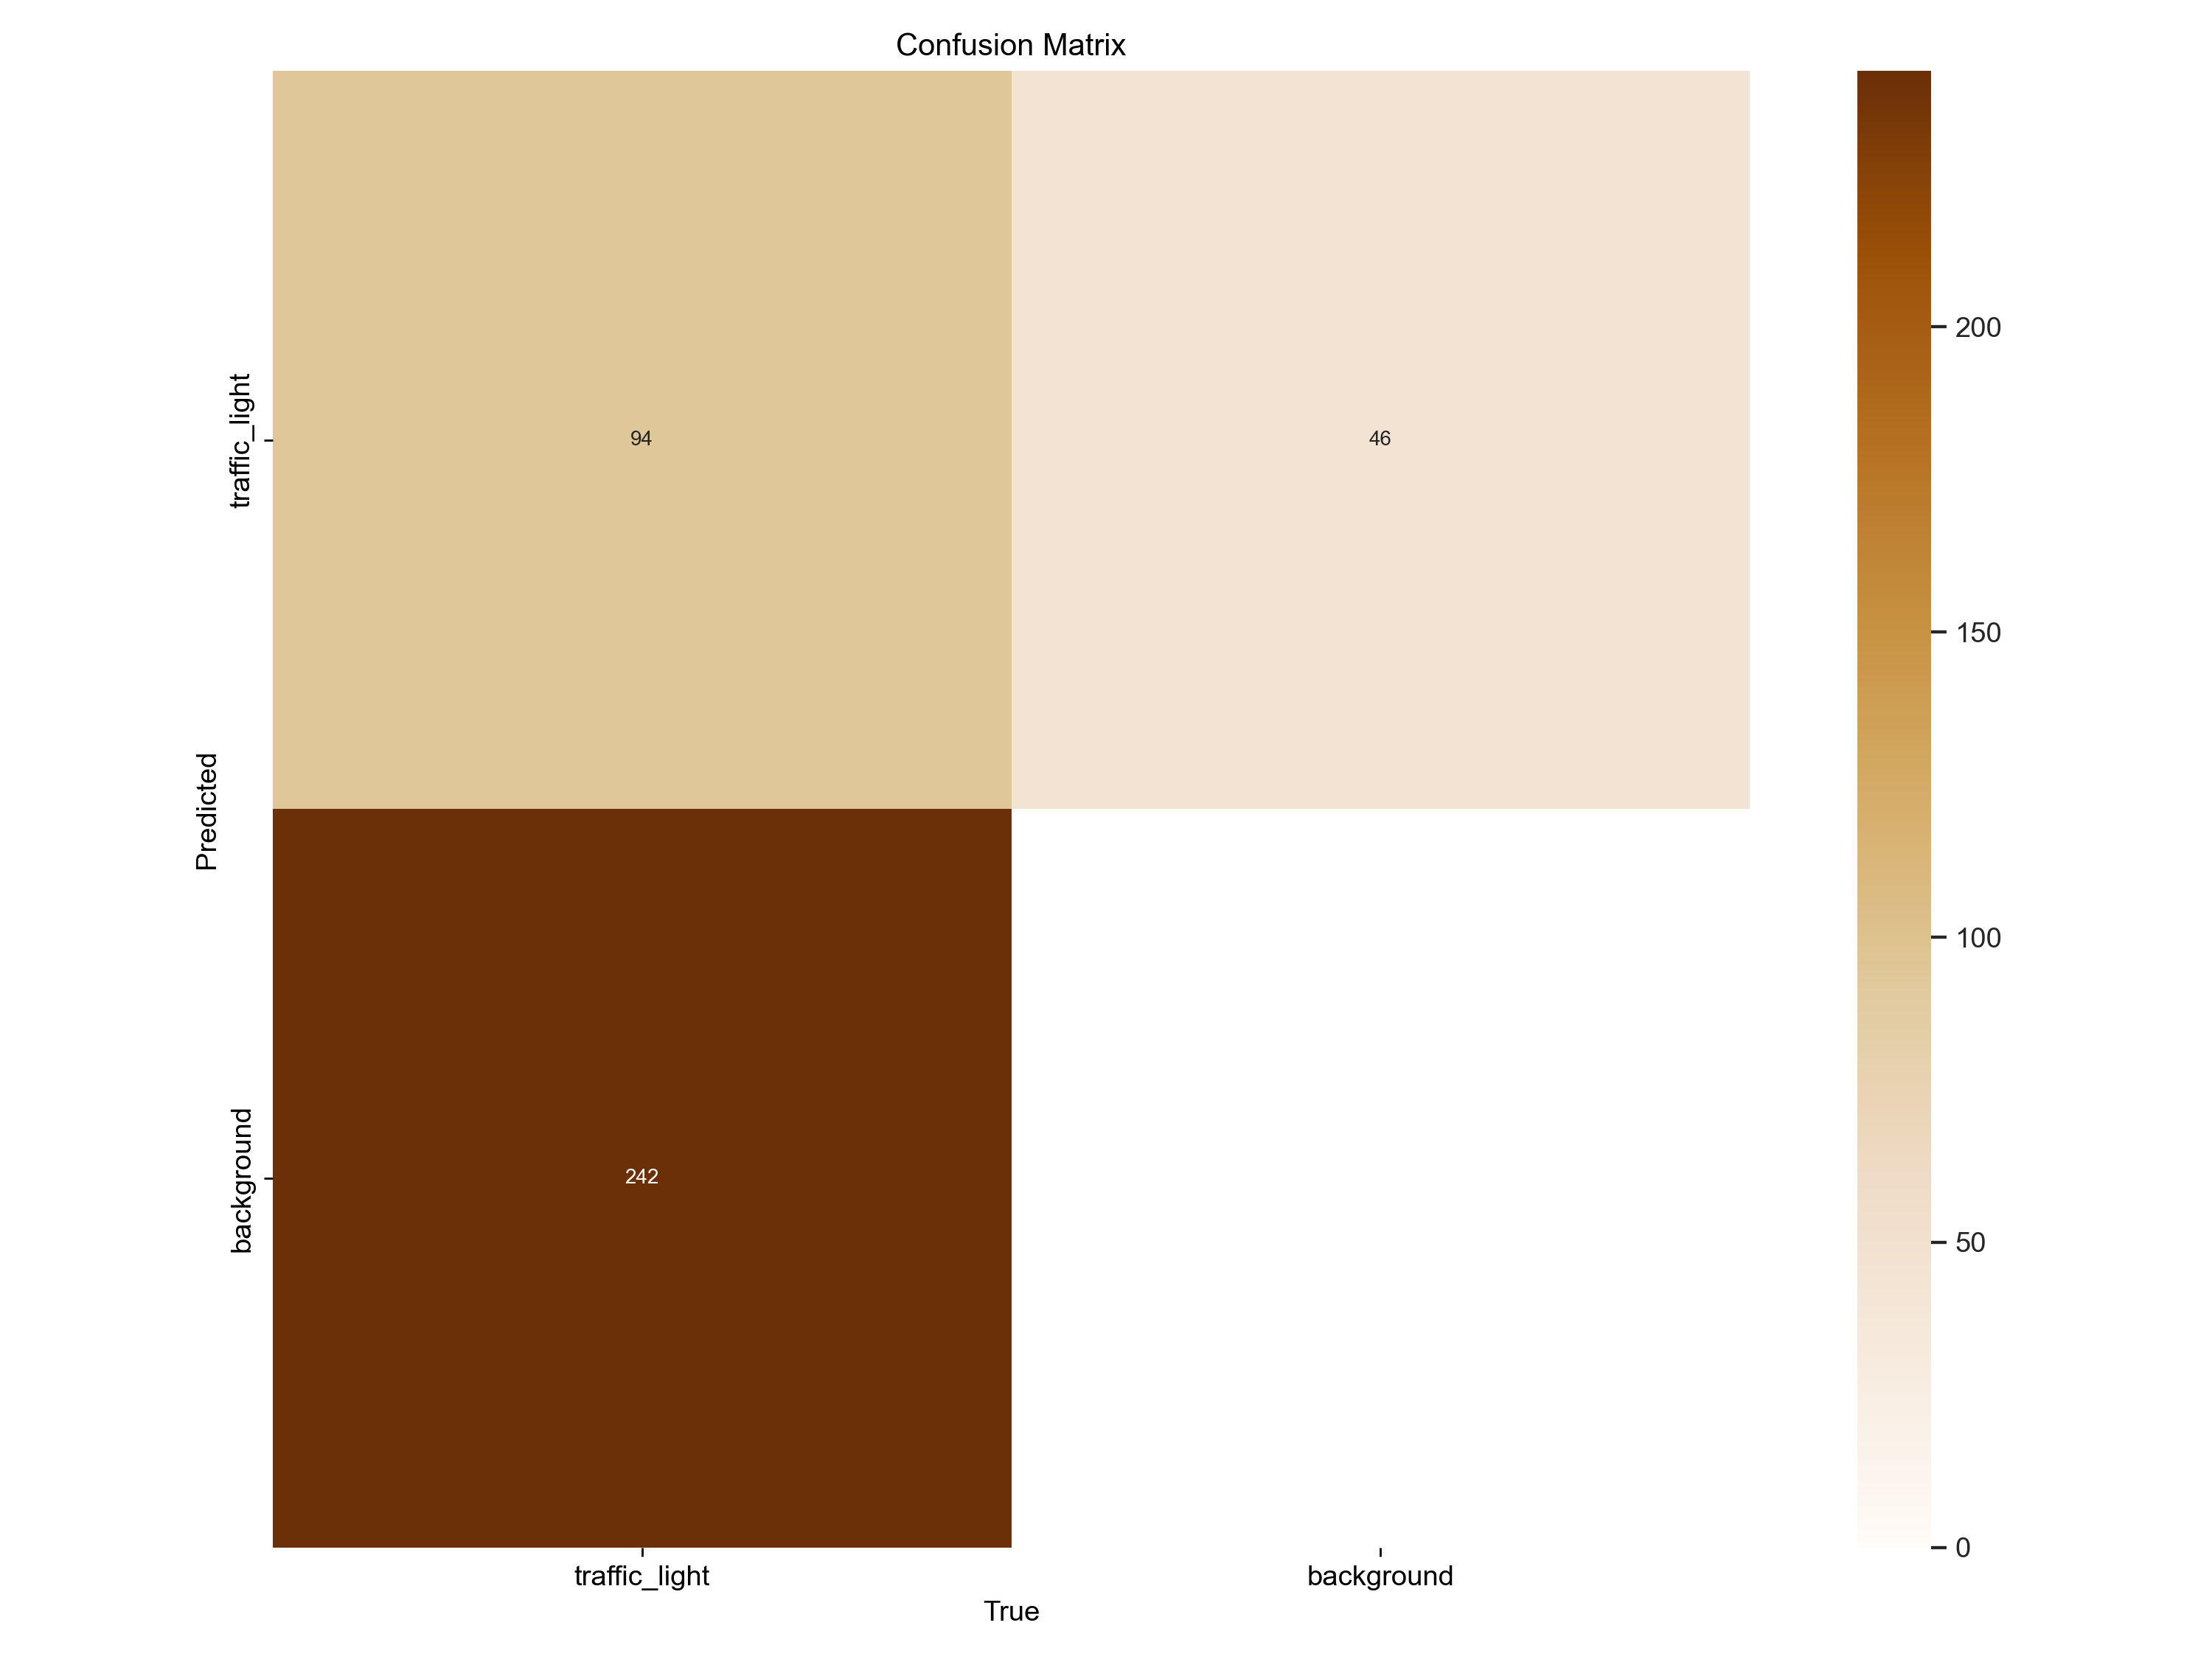

In [47]:
import cv2
from ultralytics import YOLO
from PIL import Image

imgr = cv2.imread('runs/detect/train19/confusion_matrix.png',cv2.COLOR_BGR2GRAY)

display(Image.fromarray(imgr))

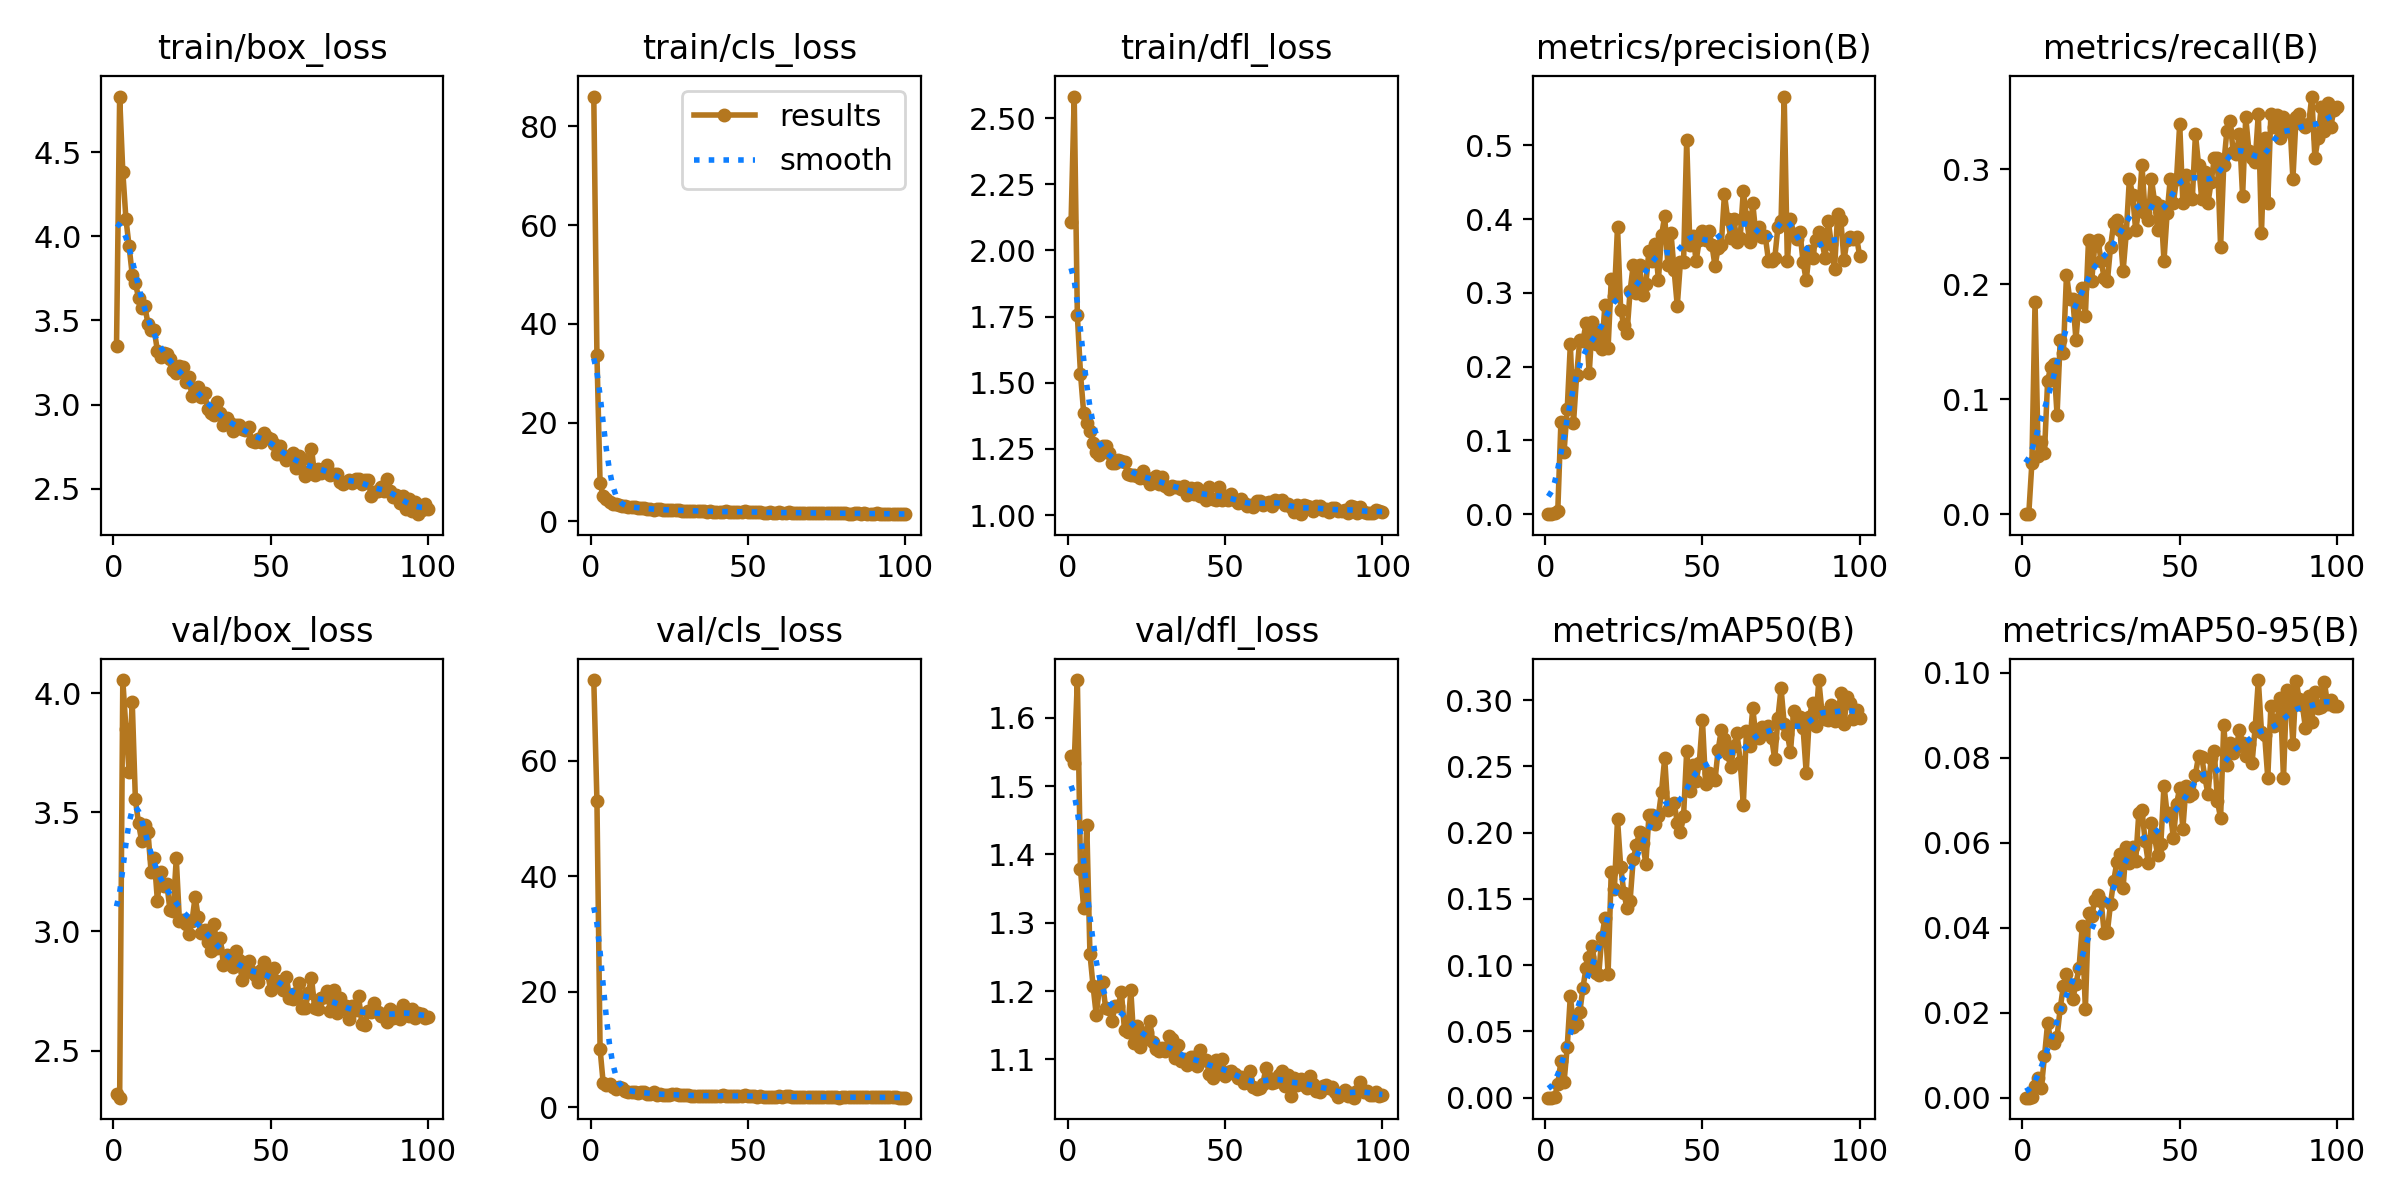

In [48]:
imgr = cv2.imread('runs/detect/train19/results.png',cv2.COLOR_BGR2GRAY)

display(Image.fromarray(imgr))

Couple of examples...

In [37]:
imgs = []
model = YOLO('runs/detect/train19/weights/best.pt')
for img in tqdm(os.listdir( 'bdd100ksample/test/images')):
    img_path = os.path.join('bdd100ksample/test/images', img)
    imgs.append(img_path)
    
for img in imgs:
    imgr = cv2.imread(img,1)
    results = model(img)[0]
    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result
        cv2.rectangle(imgr, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
        cv2.putText(imgr, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)
        cv2.imshow('',imgr)
        if cv2.waitKey(0) == ord('q'):
            break
    if cv2.waitKey(0) == ord('q'):
        cv2.destroyAllWindows()
        break      
    cv2.destroyAllWindows()

100%|█████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 66332.87it/s]



image 1/1 C:\Users\these\Desktop\tem\bdd100ksample\test\images\cac32276-a70feba7.jpg: 384x640 (no detections), 335.1ms
Speed: 8.0ms preprocess, 335.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\bdd100ksample\test\images\cb879996-ecab29b0.jpg: 384x640 (no detections), 225.0ms
Speed: 5.0ms preprocess, 225.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\bdd100ksample\test\images\cbb0e311-1082d7ff.jpg: 384x640 5 traffic_lights, 225.0ms
Speed: 4.0ms preprocess, 225.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\bdd100ksample\test\images\cc236fd9-90d374e4.jpg: 384x640 (no detections), 259.0ms
Speed: 4.0ms preprocess, 259.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\these\Desktop\tem\bdd100ksample\test\images\cc388c9e-b41eace6.jpg: 384x640 3 traffic_lights, 229.0ms
Speed:

The results of this training are not really good, but this was to be expected since out of 699 images in training set, we had over 200 background photos. Now we are going to readjust the training set to 900 photos with at least one traffic light and 27 background photos.

Train

In [ ]:
train_annotations_path = "bdd100k/train/ann"
train_annotations = load_annotations(train_annotations_path)

df = pd.DataFrame.from_dict(train_annotations, orient='columns')

df

In [ ]:
df_totals2 = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})
df_per_picture2 = pd.DataFrame({
    'car':[0],
    'bus':[0],
    'drivable area':[0],
    'lane':[0],
    'traffic sign':[0],
    'truck':[0],
    'person':[0],
    'traffic light':[0],
    'rider':[0],
    'bike':[0],
    'motor':[0],
    'train':[0]
})

for i in range(len(df.index)): 
    picture_flags = [False, False, False, False, False, False, False, False, False, False, False, False]
    for o in df.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        df_totals2.loc[0,objetcs_id_dict[o_id]] = df_totals2.loc[0,objetcs_id_dict[o_id]] + 1
        if not picture_flags[o_id]:
            df_per_picture2.loc[0,objetcs_id_dict[o_id]] = df_per_picture2.loc[0,objetcs_id_dict[o_id]] + 1
            picture_flags[o_id] = True

In [ ]:
df_totals2

In [ ]:
df_per_picture2

Val

Transformacija sample dataseta

1. Brisanje svih slika i anotacija koje ne sadrze semafor u sebi

In [ ]:
jpg_dict = {}

for picture in tqdm(os.listdir('bdd100ksample/train/images')):
       jpg_dict[picture] = False


In [ ]:
for ind in df2.index:
    for obj in df2['objects'][ind]:
        if (obj['classId']-6508800)==7:
            jpg_dict[df2['filename'][ind]] = True
            break


In [ ]:
for pair in jpg_dict:
    if not jpg_dict[pair]:
        os.remove('bdd100k/train/ann/'+pair+'.json')


2. Kopiranje slika iz celog dataseta u sample

In [ ]:
jpg_dict = {}

for ind in df.index:
    jpg_dict[df['filename'][ind]] = False
    

In [ ]:
for picture in tqdm(os.listdir('bdd100ksample/train/images')):
       jpg_dict[picture] = True

In [ ]:
import shutil
sem_picture_num = 900-435
no_sem_picture_num = 27
for ind in df.index:
    pic_filename = df['filename'][ind]
    
    if jpg_dict[pic_filename]:
        continue
        
    is_sem_pic = False
    for obj in df['objects'][ind]:
        if (obj['classId']-6508800)==7:
            shutil.copyfile('bdd100k/train/ann/'+pic_filename+'.json', 'bdd100ksample/train/ann/'+pic_filename+'.json')
            shutil.copyfile('bdd100k/train/images/'+pic_filename, 'bdd100ksample/train/images/'+pic_filename)
            sem_picture_num-=1
            is_sem_pic = True
            break
    if not is_sem_pic and no_sem_picture_num > 0:
        shutil.copyfile('bdd100k/train/ann/'+pic_filename+'.json', 'bdd100ksample/train/ann/'+pic_filename+'.json')
        shutil.copyfile('bdd100k/train/images/'+pic_filename, 'bdd100ksample/train/images/'+pic_filename)
        no_sem_picture_num-=1
    if no_sem_picture_num==0:
        break

Prikaz rezultata sa poboljsanim sample datasetom ...

Transformacija celog dataseta

1. Smanjivanje broja slika bez semafora na 1000

In [ ]:
total_no_sem = 1000
for ind in df.index:
    to_delete = True
    for obj in df['objects'][ind]:
        if (obj['classId']-6508800)==7:
            to_delete = False
            break
    if total_no_sem>0:
        total_no_sem -=1
        to_delete = False
    if to_delete:
        os.remove('bdd100k/train/ann/'+pair+'.json')
        os.remove('bdd100k/train/images/'+pair)


ponovno ucitavanje dataseta

In [ ]:
train_annotations_path = "bdd100k/train/ann"
train_annotations = load_annotations(train_annotations_path)

df = pd.DataFrame.from_dict(train_annotations, orient='columns')

df

2. Transformacija u yolo format

In [ ]:
#srediti jos

for i in range(len(df.index)):
    save_location = "bdd100k/train/labels/" + df.loc[i,'filename'].rstrip('.jpg') + ".txt"
    file = open(save_location,'w')
    for o in df.loc[i,'objects']:
        if o['classId'] - 6508800 != 7:
            continue
        str_line = ""
        str_line += ("0 ")
        str_line += (str((o['points']['exterior'][1][0]+o['points']['exterior'][0][0])/(2*1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]+o['points']['exterior'][0][1])/(2*720)) + " ")
        str_line += (str((o['points']['exterior'][1][0]-o['points']['exterior'][0][0])/(1280)) + " ")
        str_line += (str((o['points']['exterior'][1][1]-o['points']['exterior'][0][1])/(720)) + "\n")
        file.write(str_line)
    file.close()


Prikaz rezultata nad celim skupom...

In [ ]:
for i in range(len(df.index)): 
    img = cv2.imread("bdd100k/train/images/"+df.loc[i,'filename'],1)
   # print(i)
    for o in df.loc[i,'objects']:
        o_id = (o['classId']-6508800)
        if o_id != 7:
            continue
        cv2.rectangle(img,(o['points']['exterior'][0][0],o['points']['exterior'][0][1]),(o['points']['exterior'][1][0],o['points']['exterior'][1][1]),(0,0,255),2)
        cv2.imshow(df.loc[i,'filename'],img)
        if cv2.waitKey(0) == ord('q'):
            break
    if cv2.waitKey(0) == ord('q'):
        cv2.destroyAllWindows()
        break      
    cv2.destroyAllWindows()
        




In [ ]:
import os


import cv2


VIDEOS_DIR = os.path.join('.', 'videos')

video_path = 'vid5.mp4'
video_path_out = '{}_out.mp4'.format(video_path)

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))



# Load a model
model = YOLO('mod.pt')  # load a custom model

threshold = 0.5

while ret:

    results = model(frame)[0]

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()